In [14]:
import numpy as np
import matplotlib.pylab as plt

In [1]:
def preprocess(text):
    
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [2]:
def cos_similarity(x, y, eps=1e-8):
    
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

In [4]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    
    '''共起行列の作成
    
    Args:
        corpus: コーパス（単語IDのリスト）
        vocab_size:語彙数
        window_size:ウィンドウサイズ（ウィンドウサイズが1のときは、単語の左右1単語がコンテキスト）
    Returns:
        共起行列
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

In [5]:
def ppmi(C, verbose=False, eps = 1e-8):
    
    '''PPMI（正の相互情報量）の作成
    
    Args:
        C: 共起行列
        verbose: 進行状況を出力するかどうか    
    Returns:
        PPMI
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

In [7]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
corpus, word_to_id, id_to_word

(array([0, 1, 2, 3, 4, 1, 5, 6]),
 {'.': 6, 'and': 3, 'goodbye': 2, 'hello': 5, 'i': 4, 'say': 1, 'you': 0},
 {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'})

In [8]:
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
C

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [9]:
W = ppmi(C)
W

array([[0.       , 1.8073549, 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [1.8073549, 0.       , 0.8073549, 0.       , 0.8073549, 0.8073549,
        0.       ],
       [0.       , 0.8073549, 0.       , 1.8073549, 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.8073549, 0.       , 1.8073549, 0.       ,
        0.       ],
       [0.       , 0.8073549, 0.       , 1.8073549, 0.       , 0.       ,
        0.       ],
       [0.       , 0.8073549, 0.       , 0.       , 0.       , 0.       ,
        2.807355 ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 2.807355 ,
        0.       ]], dtype=float32)

In [10]:
U, S, V = np.linalg.svd(W)

In [11]:
# 単語IDが0の単語ベクトル

print(C[0]) # 共起行列
print(W[0]) # PPMI行列
print(U[0]) # SVD

[0 1 0 0 0 0 0]
[0.        1.8073549 0.        0.        0.        0.        0.       ]
[ 3.4094876e-01  0.0000000e+00 -1.2051624e-01 -3.3306691e-16
 -9.3232495e-01 -1.1102230e-16 -2.4257469e-17]


In [12]:
# 2次元に次元削除した（SVDベクトル空間から2次元だけ取り出した）単語IDが0の単語ベクトル

print(U[0, :2])

[0.34094876 0.        ]


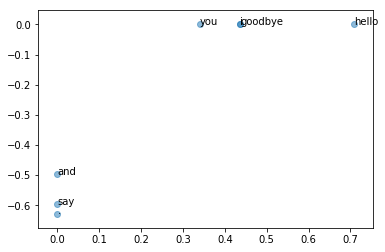

In [15]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()